In [26]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import base64
import csv
import os
import seaborn as sns
import numpy as np
from glob import glob
from shutil import copyfile

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [27]:
import xgboost
from xgboost import plot_importance

In [28]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [30]:
%cd $PROJECT_DIR
df = pd.read_csv('dataset/recipes_df10-23-2017.csv', error_bad_lines=False, encoding='utf-8', sep = '\t')

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [31]:
df = df.dropna(axis=0, how='any')
df = df.drop_duplicates(subset = 'recipe_id')
# query recipes that were added less than 1 month
df = df.query('date_x < "2017-09-02"')

In [32]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('-', '_') for c in df.columns]
df.columns = [c.replace(':', '') for c in df.columns]
df['printed_total'] = np.exp(df['printed_per_day'])*df['days_exists']
df['printed_daily'] = df['printed_total']/df['days_exists']
df['log_printed_per_day'] = df['printed_per_day']

In [33]:
stars_d = df['stars'].str.get_dummies('@').add_suffix('_stars')
difficulty_d = df['difficulty'].str.get_dummies('@').add_suffix('_diff')

df = pd.concat([df,
                stars_d,
                difficulty_d],
                axis = 1)

In [34]:
threshold = df[df['has_picture'] == 'yes']['printed_per_day'].quantile(q=0.5)
np.exp(threshold)
df['num_reviews_log'] = np.log( (df['num_reviews'] + 1) / df['days_exists'] )
df['author_posts_log'] = np.log((df['author_posts'] + 1) / df['author_reg'])
df['prep_time'] = np.log(df['prep_time'])
df['label'] = (df['printed_per_day'] >= threshold)

In [35]:
df.to_csv('dataset/fin_set.csv', sep = '\t', encoding='utf-8', index=False)

# Load prepared dataset and get feature sets

In [36]:
df = pd.read_csv('dataset/fin_set', error_bad_lines=False, encoding='utf-8', sep = '\t')
df_with_pics = df[df['has_picture'] == 'yes'].copy()

In [37]:
ing_cols = [col for col in df.columns if '_ing' in col]
tag_cols = [col for col in df.columns if '_tag' in col]
str_cols = [col for col in df.columns if '_stars' in col] 
dff_cols = [col for col in df.columns if '_diff' in col] 
all_cols = df.columns.values.tolist()
rest_cols = set(all_cols) - set(ing_cols) - set(tag_cols) - set(str_cols) - set(dff_cols)
rest_cols
author_inf = list(['author_reg', 'author_posts_log'])
search_inf = list(['avg_rating', 'num_reviews_log', 'prep_time', 'days_exists'] + str_cols + dff_cols)
dv1 =['label']
dv2 =['printed_per_day']
#author_inf
#other_cols = list(avg_rating, stars, num_reviews_100d, difficulty, prep_time, author_reg, author_posts_100d, days_exists, has_picture, )
#other_cols

# Get list of training and validation examples based on picture folders

In [6]:
PROJECT_DIR  = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PICTURES_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences\\classification_with_pics'

#Set path to sample/ path if desired
path = PICTURES_DIR + '\\sample\\'
#path = PICTURES_DIR + '\\' + 'sample\\'
results_path=path + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

model_path = path + '\\models\\'
if not os.path.exists(model_path): os.mkdir(model_path)

In [7]:
%cd $valid_path\popular
popular   = glob('*.jpg')

%cd $valid_path\unpopular
unpopular = glob('*.jpg')

validation_list = popular+unpopular
len(validation_list)

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics\sample\valid\popular
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics\sample\valid\unpopular


50

In [16]:
df_with_pics['new_name']

2    False.recipe-3333651495007708.jpg
4    False.recipe-3333561494972170.jpg
6    False.recipe-3321081493152882.jpg
7    False.recipe-3205721477169720.jpg
9     True.recipe-3336321495482842.jpg
Name: new_name, dtype: object

In [15]:
df_with_pics['new_name'] = df_with_pics['label'].astype(str) + '.' + df_with_pics['recipe_id'] + '.jpg'

In [48]:
# split data into X and y
#X = df_with_pics[search_inf]
X = df_with_pics[search_inf+author_inf]
Y = df_with_pics[dv1]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [49]:
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())
#model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [50]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.54%


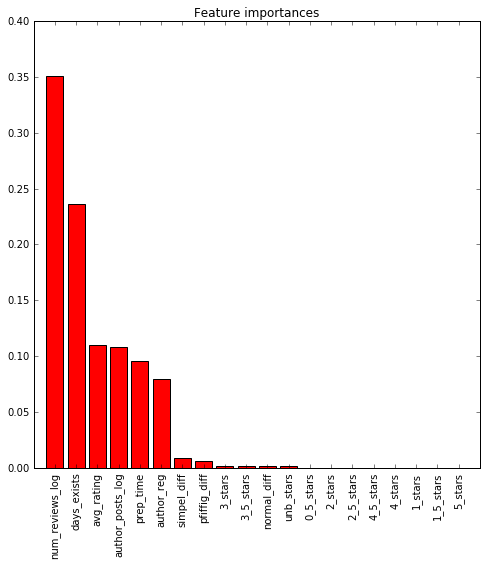

In [51]:
def feat_imp(df, model, n_features):

    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]

    plt.figure(figsize=(8,8))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation='vertical')

feat_imp(X_train, model, 20)